In [2]:
using Pkg
#Pkg.add("Distributions")
using Random, Distributions
using PyPlot
using Optim

In [3]:
function gen_support(t) 
    result = zeros(2^(2*t),t,2)
    for i=1:2^(2*t)
        i_copy = i
        binary = zeros(2*t)
        for digit=1:2*t
            if mod(i_copy,2) > 0
                binary[digit] = 1
                i_copy = i_copy - 1
            end
            i_copy = i_copy/2
        end
        result[i,:,1] = binary[1:t]
        result[i,:,2] = binary[t+1:end]
    end
    return result
end

gen_support (generic function with 1 method)

[1.0 0.0; 0.0 0.0] 1

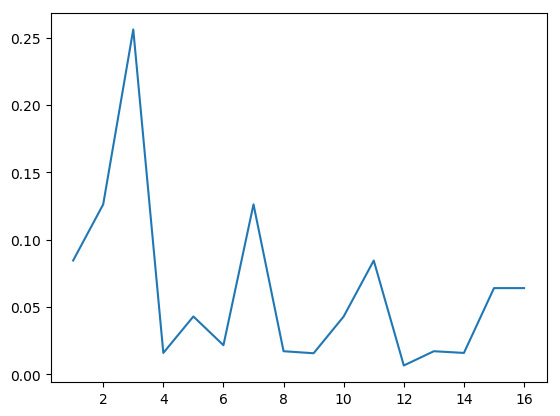


[0.0 0.0; 1.0 0.0] 2
[1.0 0.0; 1.0 0.0] 3
[0.0 1.0; 0.0 0.0] 4
[1.0 1.0; 0.0 0.0] 5
[0.0 1.0; 1.0 0.0] 6
[1.0 1.0; 1.0 0.0] 7
[0.0 0.0; 0.0 1.0] 8
[1.0 0.0; 0.0 1.0] 9
[0.0 0.0; 1.0 1.0] 10
[1.0 0.0; 1.0 1.0] 11
[0.0 1.0; 0.0 1.0] 12
[1.0 1.0; 0.0 1.0] 13
[0.0 1.0; 1.0 1.0] 14
[1.0 1.0; 1.0 1.0] 15
[0.0 0.0; 0.0 0.0] 16


In [4]:
function calc_pr(payoffs, mix; 
        beliefs=[[3 1 ; 3 1],[1 3 ; 1 3]],T=5,N=3000)
    
    #infer # of players and actions
    players = 2
    actions = 2
    support = gen_support(T)
    pr = zeros(2^(2*T))
    for x = 1:2^(2*T)
        for m=1:size(mix)[1]
            pr_xm = mix[m]
            prior = beliefs[m][:,:]
            for t = 1:T
                choices = support[x,t,:]
                for k=1:players
                    belief_t = prior[k,:]/sum(prior[k,:])
                    payoff = sum( belief_t .* payoffs[k][1,:] )
                    pr_xm = pr_xm* (exp(payoff)^choices[k]) / (1+exp(payoff))
                end
                #update prior
                for k=1:players
                    not_k = mod(k,2)+1
                    choice_index = Integer(choices[not_k]+1)
                    prior[k,choice_index] = prior[k,choice_index] +1
                end
            end
            pr[x] = pr[x] + pr_xm
        end
    end
    return pr
end


#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]

#player, action (not yours)
mix = [.5 ; .5]

T=2
sim_pr = calc_pr(payoffs,mix,T=T;)
plot(collect(1:2^(2*T)), sim_pr)

support = gen_support(T)
for i=1:2^(2*T)
    println(support[i,:,:]," $(i)")
end

In [5]:
function gmm_obj_payoffs(params, obs_pr ; T=5)   
    
    #initialize array of 0s
    moments = zeros( 2^(2*T) +1)
    
    #deal with probability parameters
    mix = [max(params[5],0) ; max(params[6],0)]
    denom = sum(mix)
    mix = mix/denom
    moments[1] = (denom -1)
    
    
    #simulate the rest of the equations
    payoffs = [ [ params[1] params[2]; 0 0 ], [params[3] params[4] ; 0 0] ]
    #subtract simulated from reality
    moments[2:end] = obs_pr - calc_pr(payoffs, mix ; T=T)
    result = sum(moments .* moments)
    return result
end

#player, action 1, action 2
payoffs = [ [3 -1 ; 0 0], [1 -3 ; 0 0] ]
#player, action (not yours)
mix = [0.5 ; 0.5]
T=2
sim_pr = calc_pr(payoffs,mix;T=T)
gmm_obj_payoffs( [3 -1 1 -3 .5 .5], sim_pr ;T=T)

0.0

In [10]:
function estimate_payoffs(obs_pr; T=5)
    obj(x) = gmm_obj_payoffs(x, obs_pr ;T=T)
        
    res = optimize(obj,[1. 2. 1. 1. .5 .5], NelderMead(),
        Optim.Options(iterations = 1000,x_tol=1e-20,f_tol=1e-20))
    return res.minimizer
end

#player, action 1, action 2
payoffs = [ [3. -1. ; 0. 0.], [1. -3. ; 0. 0.] ]
#player, action (not yours)
mix = [0.7 ; 0.3]
T=3
sim_pr = calc_pr(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

[2.9999 -0.999973 0.999671 -2.99902 0.699867 0.300123]


In [7]:
#player, action 1, action 2
payoffs = [ [1. -1. ; 0. 0.], [-1. 1. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=5
sim_pr = calc_pr(payoffs,mix;T=T)

println(estimate_payoffs(sim_pr; T=T))

[0.978472 -0.99348 -1.00382 1.00819 0.205781 0.794195]


In [13]:
#player, action 1, action 2
payoffs = [ [1. -1. ; 0. 0.], [-1. 1. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=3
sim_pr = ones(2^(2*T))/(2^(2*T))

println(estimate_payoffs(sim_pr; T=T))

[-0.00397449 0.00331492 0.000428395 0.000206279 0.432767 0.567239]


In [14]:
#player, action 1, action 2
payoffs = [ [1. -1. ; 0. 0.], [-1. 1. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=3
sim_pr = zeros(2^(2*T))
sim_pr[1:2] = [.5 .5]

println(estimate_payoffs(sim_pr; T=T))

[-7.64161 25.3945 59.7757 -298.88 1.00002 -7.87686]


In [15]:
#player, action 1, action 2
payoffs = [ [0. 0. ; 0. 0.], [0 0. ; 0. 0.] ]
#player, action (not yours)
mix = [0.2 ; 0.8]
T=3
sim_pr = zeros(2^(2*T))
sim_pr[1:2] = [.5 .5]

println(estimate_payoffs(sim_pr; T=T))

[-7.64161 25.3945 59.7757 -298.88 1.00002 -7.87686]
